In [1]:
import numpy as np
import pandas as pd
from pydicom import dcmread
import os
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms.v2 as T
import torch
import matplotlib.pyplot as plt
import tqdm
import wandb
import seaborn as sns


from src import *


train_transform = T.Compose([T.Normalize(mean=[781.0543],std=[1537.8235]),T.RandomHorizontalFlip(p=0.5),T.RandomVerticalFlip(p=0.5)])
transform = T.Compose([T.Normalize(mean=[781.0543],std=[1537.8235]),])


In [2]:
#annot["breast_density"].unique()
loader = Breast_Cancer_Dataloader(
    root_folder='/Users/jazav7774/Library/CloudStorage/OneDrive-UiTOffice365/Data/Mammo/',
        annotation_csv="modified_breast-level_annotations.csv",
        imagefolder_path="New_512",
        batch_size=32,
        num_workers=8,
        train_transform=train_transform,
        transform=transform,
)

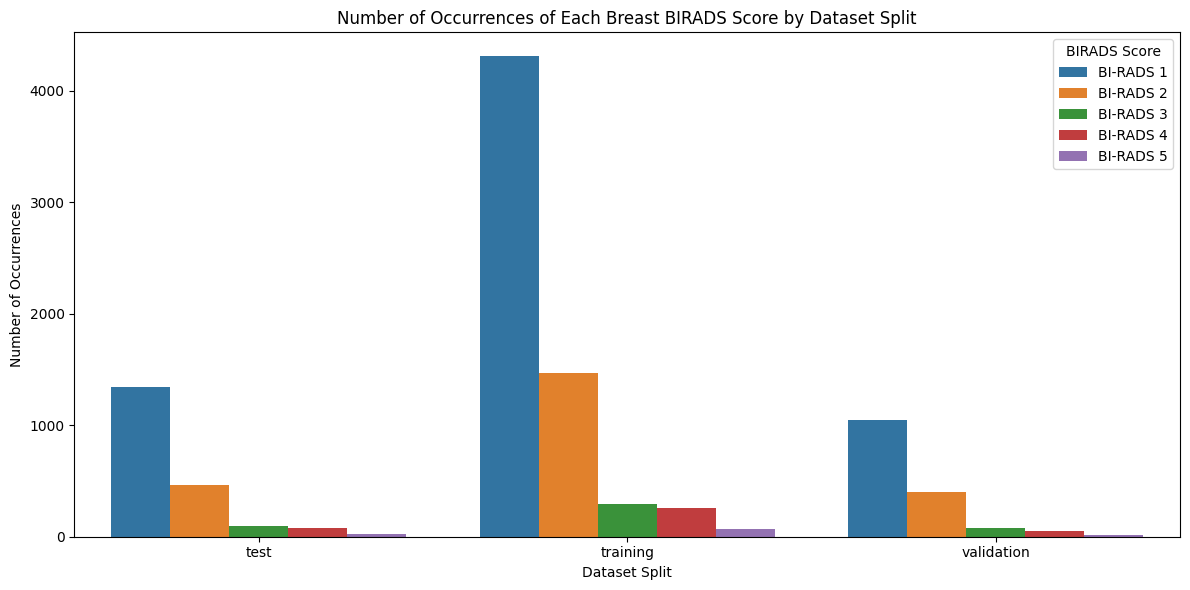

In [2]:
annot = pd.read_csv('/Users/jazav7774/Library/CloudStorage/OneDrive-UiTOffice365/Data/Mammo/modified_breast-level_annotations.csv')
annot

#split_counts = annot.groupby(['split', 'breast_birads']).size().unstack(fill_value=0)
split_counts = annot.groupby(['split', 'breast_birads']).size().reset_index(name='counts')
split_counts['counts'] = split_counts['counts']/2

# Plotting the histogram
# Plotting the histogram
plt.figure(figsize=(12, 6))
sns.barplot(data=split_counts, x='split', y='counts', hue='breast_birads')
plt.title('Number of Occurrences of Each Breast BIRADS Score by Dataset Split')
plt.xlabel('Dataset Split')
plt.ylabel('Number of Occurrences')
plt.legend(title='BIRADS Score')
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()

# Histograms and presentation for Patient Cancer Dataloader

In [30]:
def get_labels_from_loader(loader):
    train_labels = []
    val_labels = []
    test_labels = []
    train_loader = loader.train_dataloader()
    for i, batch in enumerate(tqdm.tqdm(train_loader, desc="Train Loader")):
        if len(batch) == 2:
            _, label = batch
        else:
            _, label, _ = batch
        #print(i, type(label), label.shape)
        train_labels.append(label.numpy())
    val_loader = loader.val_dataloader()
    for i, batch in enumerate(tqdm.tqdm(val_loader, desc="Validation Loader")):
        if len(batch) == 2:
            images, label = batch
        else:
            images, label, _ = batch
        #print(i, type(label), label.shape)
        val_labels.append(label.numpy())
    test_loader = loader.test_dataloader()
    for i, batch in enumerate(tqdm.tqdm(test_loader, desc="Test Loader")):
        if len(batch) == 2:
            images, label = batch
        else:
            images, label, _ = batch
        #print(i, type(label), label.shape)
        test_labels.append(label.numpy())
    train_labels = np.concatenate(train_labels)
    val_labels = np.concatenate(val_labels)
    test_labels = np.concatenate(test_labels)
    return train_labels, val_labels, test_labels

In [ ]:
loader = Patient_Cancer_Dataloader(
        root_folder='/Users/jazav7774/Library/CloudStorage/OneDrive-UiTOffice365/Data/Mammo/',
        annotation_csv="modified_breast-level_annotations.csv",
        imagefolder_path="New_512",
        batch_size=16,
        num_workers=8,
        train_transform=train_transform,
        transform=transform,
    )
train_labels, val_labels, test_labels = get_labels_from_loader(loader)


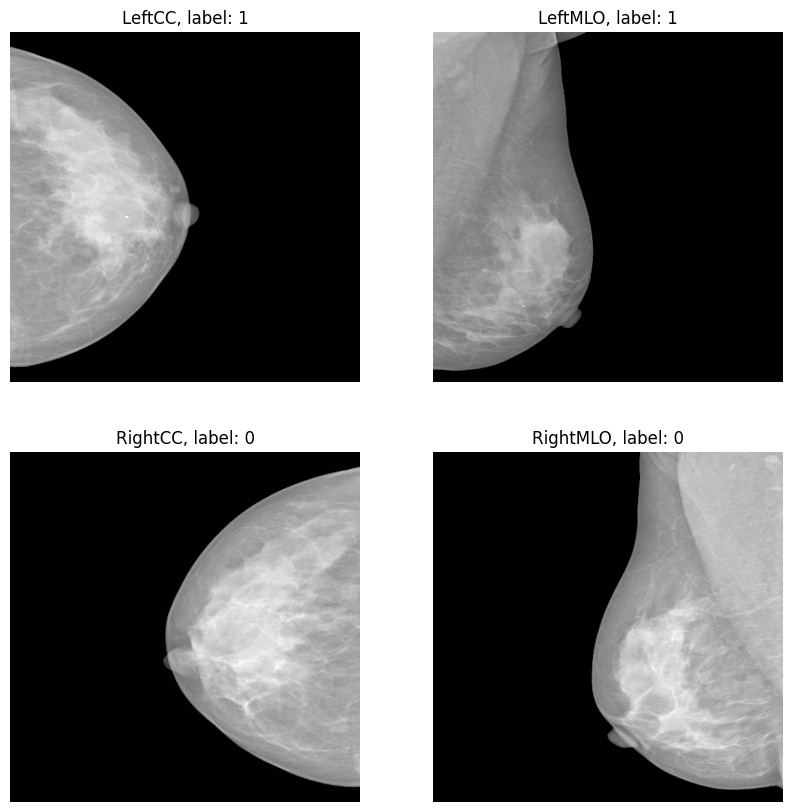

In [26]:
#print(train_labels.shape, val_labels.shape, test_labels.shape)
loader.plot(9)

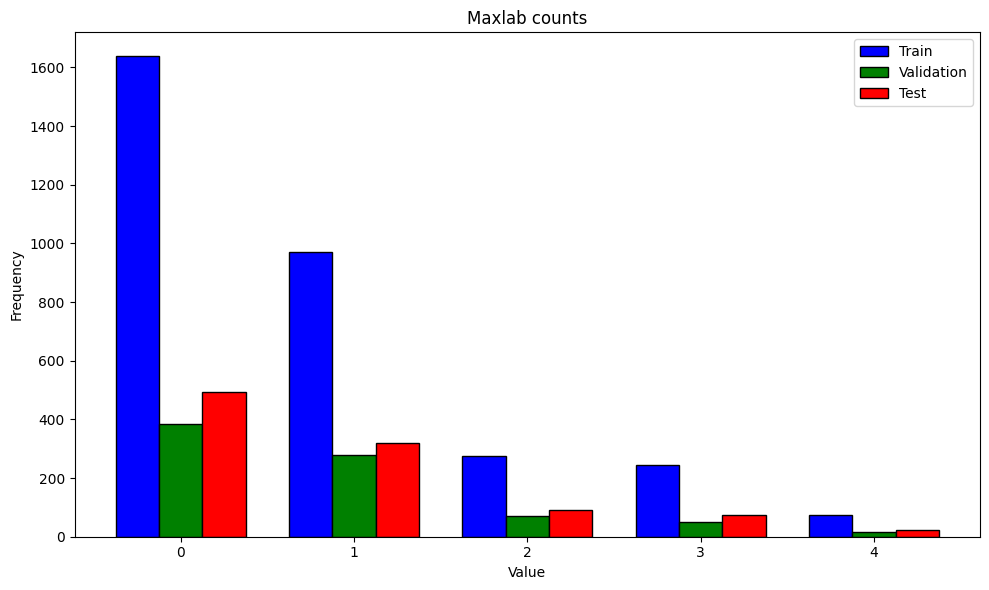

In [27]:

train_maxlab = np.max(train_labels, axis = 1)
val_maxlab = np.max(val_labels, axis = 1)
test_maxlab = np.max(test_labels, axis = 1)
# Count unique values in maxlab vectors
train_counts = np.unique(train_maxlab, return_counts=True)
val_counts = np.unique(val_maxlab, return_counts=True)
test_counts = np.unique(test_maxlab, return_counts=True)

# Plot bar graphs in one figure
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.25
index = np.arange(len(train_counts[0]))

bar1 = ax.bar(index, train_counts[1], bar_width, label='Train', color='b', edgecolor='black')
bar2 = ax.bar(index + bar_width, val_counts[1], bar_width, label='Validation', color='g', edgecolor='black')
bar3 = ax.bar(index + 2 * bar_width, test_counts[1], bar_width, label='Test', color='r', edgecolor='black')

ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('Maxlab counts')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(train_counts[0])
ax.legend()

plt.tight_layout()
plt.show()

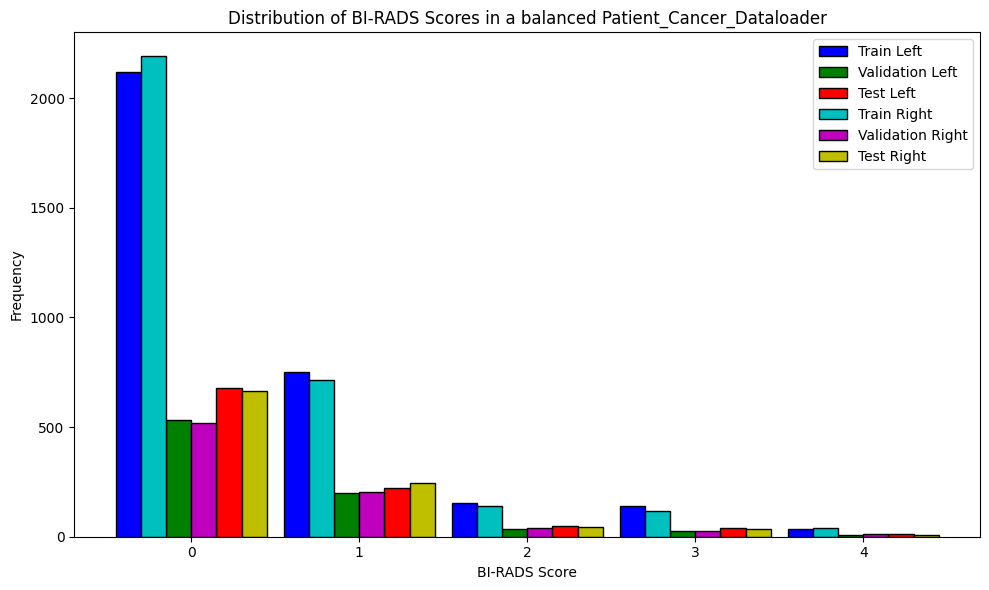

In [28]:

# Separate left and right breast labels
train_left = train_labels[:, 0]
train_right = train_labels[:, 1]
val_left = val_labels[:, 0]
val_right = val_labels[:, 1]
test_left = test_labels[:, 0]
test_right = test_labels[:, 1]

# Count unique values for left and right breast labels
train_left_counts = np.unique(train_left, return_counts=True)
train_right_counts = np.unique(train_right, return_counts=True)
val_left_counts = np.unique(val_left, return_counts=True)
val_right_counts = np.unique(val_right, return_counts=True)
test_left_counts = np.unique(test_left, return_counts=True)
test_right_counts = np.unique(test_right, return_counts=True)


# Plot bar graphs in one figure
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.15
index = np.arange(len(train_left_counts[0]))

# Plot for left breast
bar1 = ax.bar(index, train_left_counts[1], bar_width, label='Train Left', color='b', edgecolor='black')
bar2 = ax.bar(index + 2 * bar_width, val_left_counts[1], bar_width, label='Validation Left', color='g', edgecolor='black')
bar3 = ax.bar(index + 4 * bar_width, test_left_counts[1], bar_width, label='Test Left', color='r', edgecolor='black')

# Plot for right breast
bar4 = ax.bar(index + bar_width, train_right_counts[1], bar_width, label='Train Right', color='c', edgecolor='black')
bar5 = ax.bar(index + 3 * bar_width, val_right_counts[1], bar_width, label='Validation Right', color='m', edgecolor='black')
bar6 = ax.bar(index + 5 * bar_width, test_right_counts[1], bar_width, label='Test Right', color='y', edgecolor='black')

ax.set_xlabel('BI-RADS Score')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of BI-RADS Scores in a balanced Patient_Cancer_Dataloader')
ax.set_xticks(index + 2.5 * bar_width)
ax.set_xticklabels(train_left_counts[0])
ax.legend()

plt.tight_layout()
plt.show()

# Histogram and presentation for View Cancer Dataloader

Test Loader: 100%|██████████| 250/250 [00:56<00:00,  4.40it/s]


12800


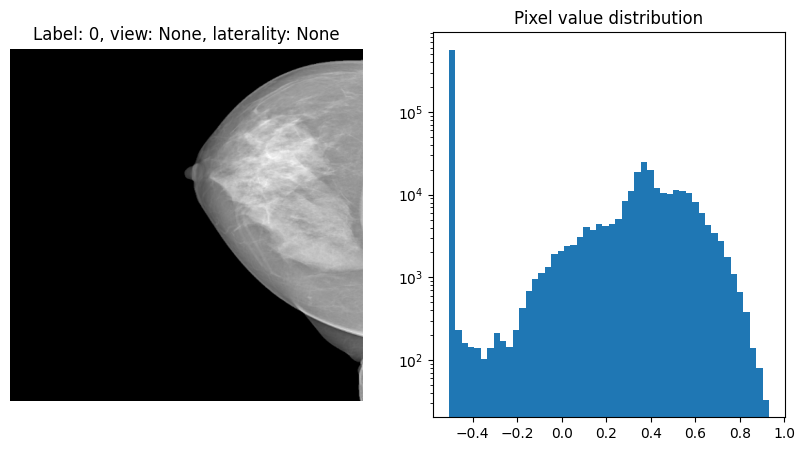

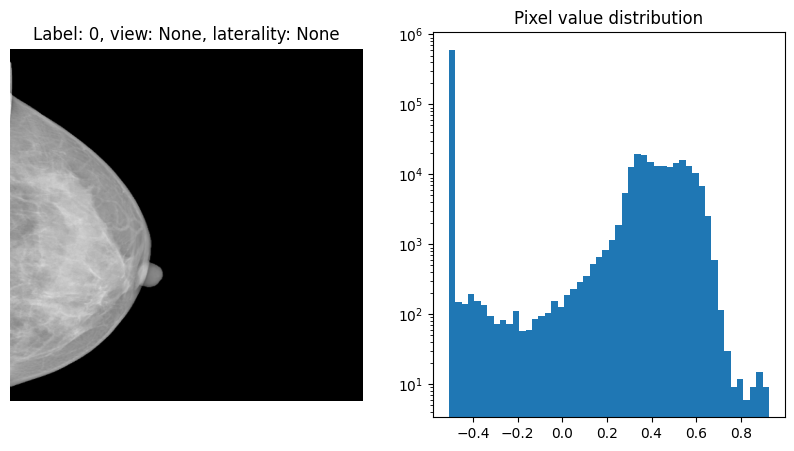

Compose(
      ToImage()
      ToDtype(scale=True)
      Normalize(mean=[781.0543, 781.0543, 781.0543], std=[1537.8235, 1537.8235, 1537.8235], inplace=False)
      RandomHorizontalFlip(p=0.5)
      RandomVerticalFlip(p=0.5)
)

In [ ]:
view_loader = View_Cancer_Dataloader(
    root_folder='/Users/jazav7774/Library/CloudStorage/OneDrive-UiTOffice365/Data/Mammo/',
    annotation_csv="modified_breast-level_annotations.csv",
    imagefolder_path="New_512",
    batch_size=16,
    num_workers=8,
    train_transform=train_transform,
    transform=transform
)
train_labels, val_labels, test_labels = get_labels_from_loader(view_loader)
print(view_loader.train_dataset.__len__())
view_loader.plot(4)
view_loader.train_transform

(12800,) (3196,) (4000,)


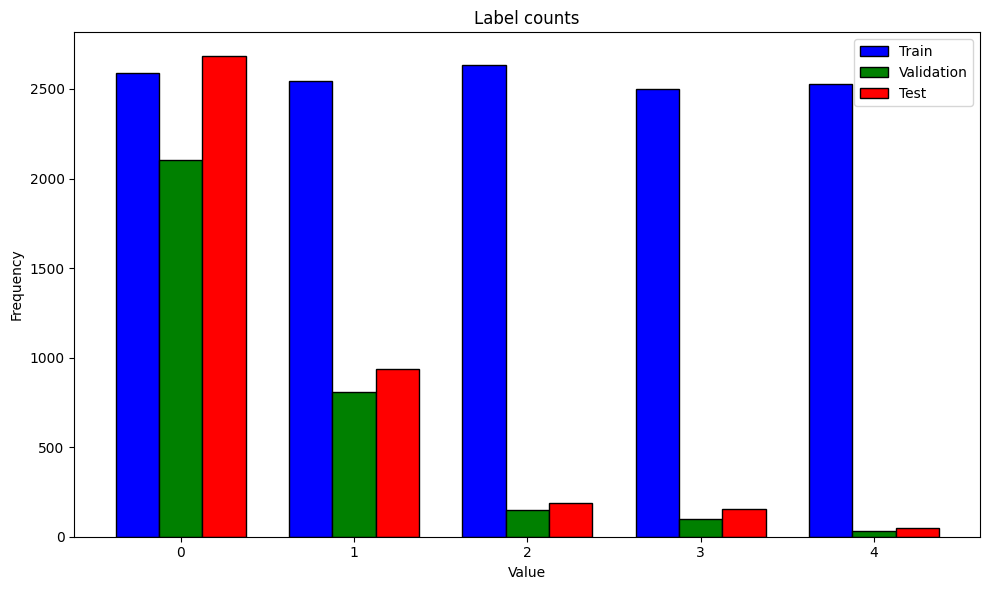

In [ ]:
print(train_labels.shape, val_labels.shape, test_labels.shape)

# Count unique values in labels vectors
train_counts = np.unique(train_labels, return_counts=True)
val_counts = np.unique(val_labels, return_counts=True)
test_counts = np.unique(test_labels, return_counts=True)

# Plot bar graphs in one figure
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.25
index = np.arange(len(train_counts[0]))

bar1 = ax.bar(index, train_counts[1], bar_width, label='Train', color='b', edgecolor='black')
bar2 = ax.bar(index + bar_width, val_counts[1], bar_width, label='Validation', color='g', edgecolor='black')
bar3 = ax.bar(index + 2 * bar_width, test_counts[1], bar_width, label='Test', color='r', edgecolor='black')

ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('Label counts')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(train_counts[0])
ax.legend()

plt.tight_layout()
plt.show()

# Breast cancer dataloader - histogram, presentation

In [31]:
breast_loader = Breast_Cancer_Dataloader(
    root_folder='/Users/jazav7774/Library/CloudStorage/OneDrive-UiTOffice365/Data/Mammo/',
    annotation_csv="modified_breast-level_annotations.csv",
    imagefolder_path="New_512",
    batch_size=16,
    num_workers=8,
    train_transform=train_transform,
    transform=transform
)
train_labels, val_labels, test_labels = get_labels_from_loader(breast_loader)


Test Loader: 100%|██████████| 125/125 [00:38<00:00,  3.28it/s]


6400
Length of train dataset: 6400


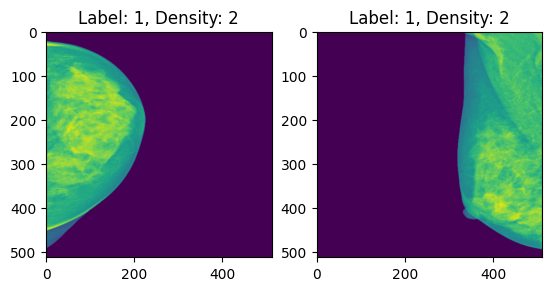

Compose(
      Normalize(mean=[781.0543], std=[1537.8235], inplace=False)
      RandomHorizontalFlip(p=0.5)
      RandomVerticalFlip(p=0.5)
)

In [32]:
print(breast_loader.train_dataset.__len__())
breast_loader.plot(0)
breast_loader.train_transform

(6400,) (1598,) (2000,)


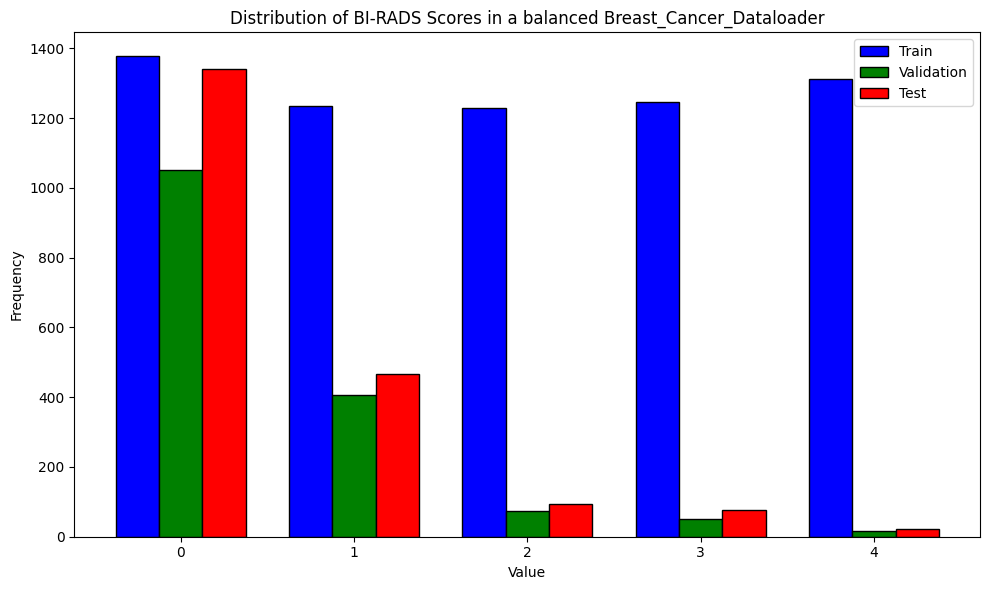

In [33]:
print(train_labels.shape, val_labels.shape, test_labels.shape)

# Count unique values in labels vectors
train_counts = np.unique(train_labels, return_counts=True)
val_counts = np.unique(val_labels, return_counts=True)
test_counts = np.unique(test_labels, return_counts=True)

# Plot bar graphs in one figure
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.25
index = np.arange(len(train_counts[0]))

bar1 = ax.bar(index, train_counts[1], bar_width, label='Train', color='b', edgecolor='black')
bar2 = ax.bar(index + bar_width, val_counts[1], bar_width, label='Validation', color='g', edgecolor='black')
bar3 = ax.bar(index + 2 * bar_width, test_counts[1], bar_width, label='Test', color='r', edgecolor='black')

ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of BI-RADS Scores in a balanced Breast_Cancer_Dataloader')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(train_counts[0])
ax.legend()

plt.tight_layout()
plt.show()

# Test loop for single resnet featurizer on all views

In [34]:
model = Four_view_single_featurizer(num_class = 5, weights_file = 'checkpoints/One_view_resnet.ckpt')
dataloader = View_Cancer_Dataloader(root_folder="/Users/jazav7774/Library/CloudStorage/OneDrive-UiTOffice365/Data/Mammo/", annotation_csv="modified_breast-level_annotations.csv", imagefolder_path="New_512", batch_size=64, num_workers=8, train_transform=train_transform, transform=transform)

trainer = pl.Trainer(max_epochs=100,accelerator='mps',devices=1,)

trainer.test(model, dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Testing: |          | 0/? [00:00<?, ?it/s]

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[64, 512, 512, 3] to have 3 channels, but got 512 channels instead

# Test loop for trained 4v2b

In [ ]:
api = wandb.Api()
artifact = api.artifact('hzavadil98/Four_view_two_branch_model/model-yid8c7p4:v16', type='model')
artifact_dir = artifact.download()


wandb: Downloading large artifact model-yid8c7p4:v16, 515.15MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_acc_left         0.5087891817092896
    test_acc_overall        0.44162094593048096
     test_acc_right         0.5084462761878967
      test_f1_left          0.4886365234851837
     test_f1_overall        0.4051537811756134
      test_f1_right         0.49079012870788574
     test_loss_left         0.7741560935974121
    test_loss_overall       1.1194634437561035
     test_loss_right        0.7430365681648254
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_left': 0.7741560935974121,
  'test_f1_left': 0.4886365234851837,
  'test_acc_left': 0.5087891817092896,
  'test_loss_right': 0.7430365681648254,
  'test_f1_right': 0.49079012870788574,
  'test_acc_right': 0.5084462761878967,
  'test_loss_overall': 1.1194634437561035,
  'test_f1_overall': 0.4051537811756134,
  'test_acc_overall': 0.44162094593048096}]

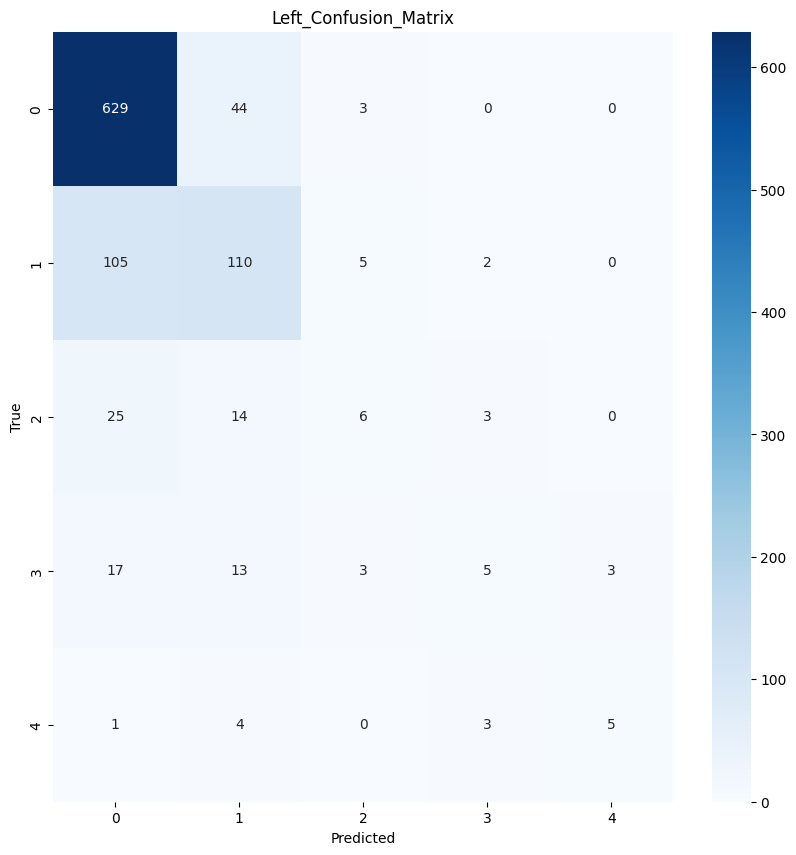

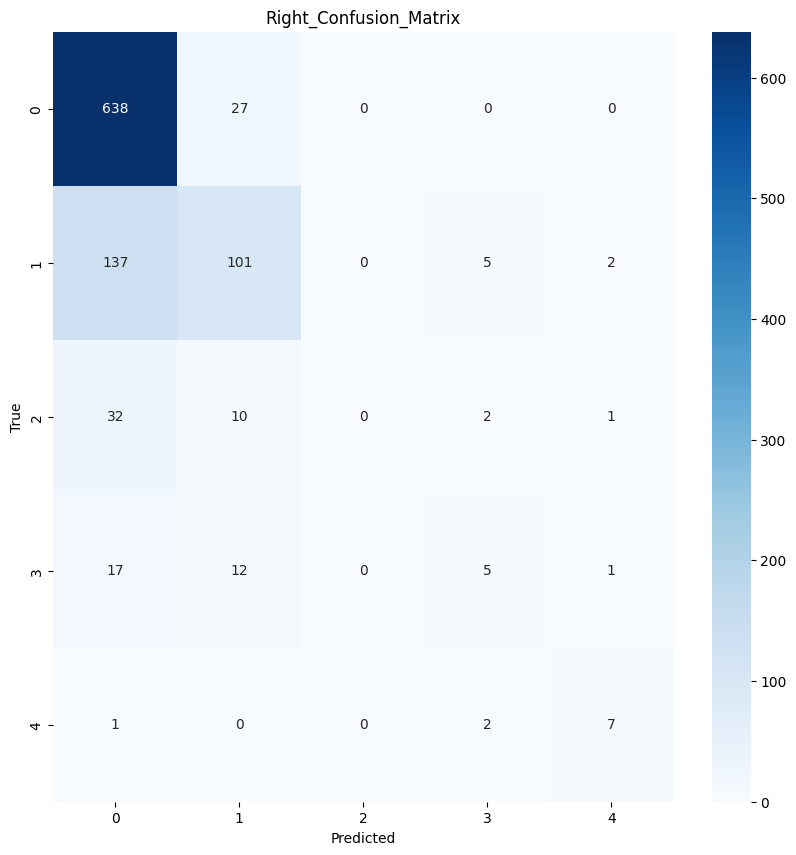

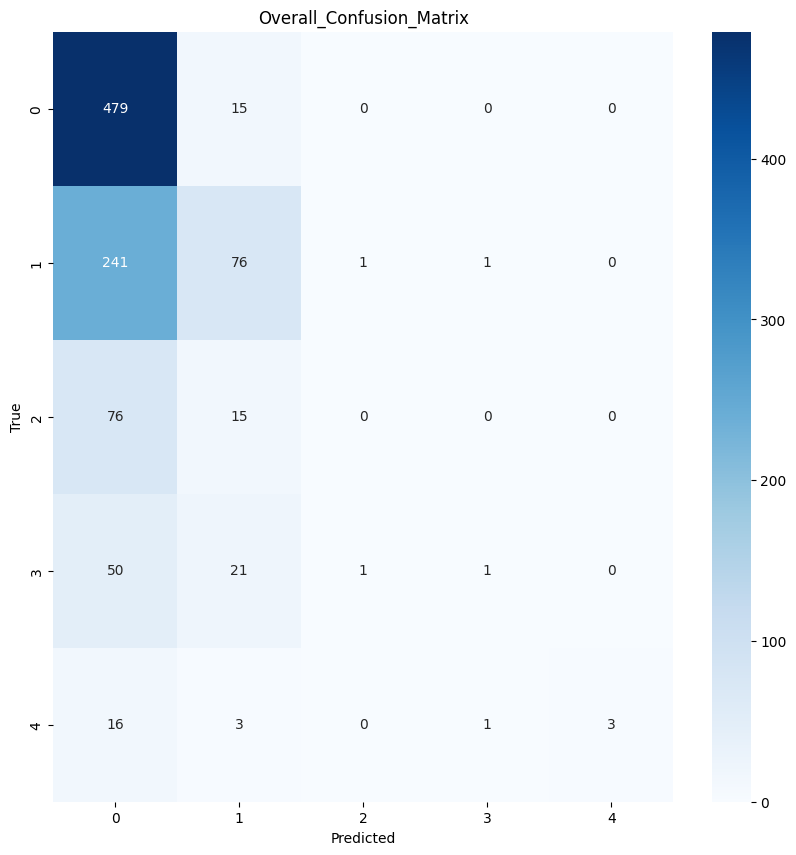

In [ ]:
#model1 = Four_view_two_branch_model(num_class = 5, weights_file = 'checkpoints/One_view_resnet.ckpt')
#model1 = Four_view_two_branch_model.load_from_checkpoint("checkpoints/4v2b_best_epoch-epoch=08.ckpt")
model1 = Four_view_two_branch_model.load_from_checkpoint('artifacts/model-yid8c7p4:v16/model.ckpt')

dataloader = Patient_Cancer_Dataloader(root_folder="/Users/jazav7774/Library/CloudStorage/OneDrive-UiTOffice365/Data/Mammo/", annotation_csv="modified_breast-level_annotations.csv", imagefolder_path="New_512", batch_size=16, num_workers=8, train_transform=train_transform, transform=transform)

trainer = pl.Trainer(max_epochs=100,accelerator='mps',devices=1)

trainer.test(model1, dataloader)

In [ ]:
model1.resnets[0].parameters()


<generator object Module.parameters at 0x168f84ba0>

# Test loop for trained 4v2b

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/jazav7774/Library/CloudStorage/OneDrive-UiTOffice365/UiT/FYS-8603/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc           6.595589013095071e+32
         test_f1            0.4686471223831177
        test_loss           0.8123522996902466
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.8123522996902466,
  'test_f1': 0.4686471223831177,
  'test_acc': 6.595589013095071e+32}]

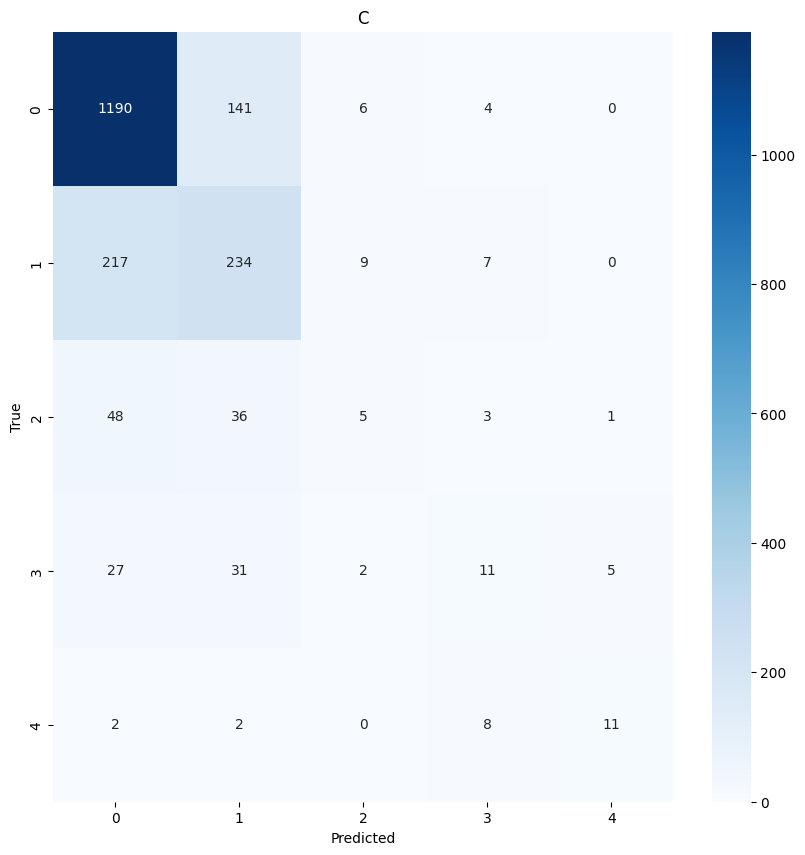

In [ ]:

model1 = Two_view_model.load_from_checkpoint('artifacts/model-q3vgirao:v12/model.ckpt')
dataloader = Breast_Cancer_Dataloader(root_folder="/Users/jazav7774/Library/CloudStorage/OneDrive-UiTOffice365/Data/Mammo/", annotation_csv="modified_breast-level_annotations.csv", imagefolder_path="New_512", batch_size=16, num_workers=8, train_transform=train_transform, transform=transform)

trainer = pl.Trainer(max_epochs=100,accelerator='mps',devices=1)

trainer.test(model1, dataloader)